# Computation of `MAF` metrics in bulk

## Introduction

This notebook gives an example of code to compute many metrics (and make corresponding plots) on each of many opsim simulation run databases.
It assumes familiarity with computing metrics on a single run, for example following the instructions in the `Introduction to MAF` notebook.

This is not normally something that should be done in a notebook.
Instead, we recommend that users write stand-alone python scripts.

This notebook only covers the computation of the metrics and creating of files with the plots.
Interactive examination of the results of the bulk computation is covered in the `Comparing Runs` notebook.

## Notebook preparation

The following is a development style aid; only uncomment if developing the notebook:

In [1]:
%load_ext lab_black
%load_ext pycodestyle_magic
%flake8_on --ignore E501,W505

## Import the required python modules

In [2]:
import rubin_sim
from rubin_sim import maf

Loading BokehJS ...

## Set the storage directory for this notebook

This notebook will produce output files, which need to go somewhere.
These files will later be read and examined using the `Comparing Runs` notebook.

The following cell will create a directory to work in as a subdirectory of the current directory. Rename it to put the data samewhere else.

In [3]:
from os import path
from os import getcwd

data_dir = path.join(getcwd(), "bulk_metric_data")

If the directory doesn't already exist, create it:

In [4]:
from os import makedirs

if not path.exists(data_dir):
    makedirs(data_dir)

## Get databases to work with

To calculate metrics, we first need the data from simulations to run metrics on.

Set the run names we will use:

In [5]:
opsim_runs = (
    "baseline_nexp2_v1.7_10yrs",
    "baseline_2snaps_v1.5_10yrs",
    "baseline_v2.0_10yrs",
    "long_gaps_nightsoff4_v2.0_10yrs",
    "footprint_4_v1.710yrs",
    "rolling_ns3_rw0.9_v2.0_10yrs",
)

If you already have a couple of opsim database to work with, uncomment these lines and set the file names to use:

In [6]:
# my_opsim_run_path = '/my/path'
# opsim_run_fnames = {run: os.path.join(my_opsim_run_path, run + '.db') for run in opsim_runs}

Otherwise, the databases will be downloaded from the URLs specified here:

In [7]:
opsim_run_urls = {
    "baseline_nexp2_v1.7_10yrs": "https://lsst.ncsa.illinois.edu/sim-data/sims_featureScheduler_runs1.7/baseline/baseline_nexp2_v1.7_10yrs.db",
    "baseline_2snaps_v1.5_10yrs": "https://lsst.ncsa.illinois.edu/sim-data/sims_featureScheduler_runs1.5/baseline/baseline_2snaps_v1.5_10yrs.db",
    "baseline_v2.0_10yrs": "https://lsst.ncsa.illinois.edu/sim-data/sims_featureScheduler_runs2.0/baseline/baseline_v2.0_10yrs.db",
    "long_gaps_nightsoff4_v2.0_10yrs": "https://lsst.ncsa.illinois.edu/sim-data/sims_featureScheduler_runs2.0/long_gaps/long_gaps_nightsoff4_v2.0_10yrs.db",
    "footprint_4_v1.710yrs": "https://lsst.ncsa.illinois.edu/sim-data/sims_featureScheduler_runs1.7/footprint_tune/footprint_4_v1.710yrs.db",
    "rolling_ns3_rw0.9_v2.0_10yrs": "https://lsst.ncsa.illinois.edu/sim-data/sims_featureScheduler_runs2.0/rolling/rolling_ns3_rw0.9_v2.0_10yrs.db",
}

Now, actually download the files if (and only if) necessary:

In [8]:
from os import path
import urllib

for opsim_run in opsim_runs:
    if "opsim_run_fnames" not in locals():
        opsim_run_fnames = {}

    opsim_run_fname = path.join(data_dir, opsim_run + ".db")
    if opsim_run not in opsim_run_fnames:
        opsim_run_fnames[opsim_run] = opsim_run_fname

    if not path.isfile(opsim_run_fname):
        opsim_run_url = opsim_run_urls[opsim_run]
        print(f"Downloading {opsim_run_url} to {opsim_run_fname}")
        opsim_db_file = urllib.request.urlretrieve(opsim_run_url, opsim_run_fname)
        print("Download complete")

Now we have a dictionary with the database file names for the runs we want:

In [9]:
opsim_run_fnames

{'baseline_nexp2_v1.7_10yrs': '/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_nexp2_v1.7_10yrs.db',
 'baseline_2snaps_v1.5_10yrs': '/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_2snaps_v1.5_10yrs.db',
 'baseline_v2.0_10yrs': '/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_v2.0_10yrs.db',
 'long_gaps_nightsoff4_v2.0_10yrs': '/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/long_gaps_nightsoff4_v2.0_10yrs.db',
 'footprint_4_v1.710yrs': '/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/footprint_4_v1.710yrs.db',
 'rolling_ns3_rw0.9_v2.0_10yrs': '/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/rolling_ns3_rw0.9_v2.0_10yrs.db'}

## Computing many metrics for multiple runs

### The high-level workflow

To compute metrics for many runs, we follow the same workflow we used for a single run (e.g. in `Introduction to MAF`), except:
- we need to iterate over all runs; and
- we save the results in a dictionory, whose keys are the run names.

In each iteration, we need to construct all of the elements used to construct the `maf.MetricBundleGroup` that we use to compute the metrics and make the plots.

We separate the creation of each set of `maf.MetricBundle`s into a separate function.
Such a set of `MetricBundle`s for a run is called a `batch`.
Because running a `MetricBundleGroup` modifies the state of elements of the `batch` it is passed, including storing the values of the metrics themselves, a compelete new batch needs to be created for each run.

### Creating metric bundles

To separate the code into manageable units, define functions to create the metric bundles you want, as shown in the Introduction to MAF notebook.

Start with one that computes the open shutter fraction for the survey:

In [10]:
def make_open_shutter_bundle(run_name):
    constraint = ""
    plotDict = {}
    slicer = maf.UniSlicer()
    metric = maf.OpenShutterFractionMetric(
        slewTimeCol="slewTime", expTimeCol="visitExposureTime", visitTimeCol="visitTime"
    )
    summary_metrics = [maf.IdentityMetric()]
    bundle = maf.MetricBundle(
        metric,
        slicer,
        constraint,
        summaryMetrics=summary_metrics,
        runName=run_name,
        plotDict=plotDict,
    )

    return bundle

Let's also make depth maps:

In [11]:
import numpy as np


def make_depth_map_bundle(run_name, band, footprint_area):
    constraint = f"filter = '{band}'"
    plotDict = {}
    slicer = maf.HealpixSlicer(nside=64)
    metric = maf.Coaddm5Metric()

    # Summary stats for depth over best footprint area
    summary_metrics = [
        maf.AreaSummaryMetric(
            area=footprint_area,
            reduce_func=np.min,
            decreasing=True,
            metricName="Min",
        ),
        maf.AreaSummaryMetric(
            area=footprint_area,
            reduce_func=np.median,
            decreasing=True,
            metricName="Median",
        ),
        maf.AreaSummaryMetric(
            area=footprint_area,
            reduce_func=np.max,
            decreasing=True,
            metricName="Max",
        ),
    ]

    bundle = maf.MetricBundle(
        metric,
        slicer,
        constraint,
        summaryMetrics=summary_metrics,
        runName=run_name,
        plotDict=plotDict,
    )

    return bundle

Finally, sets make an airmass distribution:

In [12]:
def make_airmass_bundle(run_name):
    constraint = ""
    plotDict = {}
    slicer = maf.OneDSlicer(
        sliceColName="airmass", binMin=1.0, binMax=2.5, binsize=0.05
    )
    metric = maf.CountMetric(col="airmass")

    # produces list of metrics with mean, median, RMS, etc.
    summary_metrics = maf.extendedSummary()

    bundle = maf.MetricBundle(
        metric,
        slicer,
        constraint,
        summaryMetrics=summary_metrics,
        runName=run_name,
        plotDict=plotDict,
    )
    return bundle

### Creating batches

Now we need a function to create batches of metric bundles that can be used to compute metrics for a run:

In [13]:
def sample_batch(run_name="opsim", bands=("g", "i"), footprint_area=18000):
    metric_bundles = []

    # Open shutter fraction on each night
    bundle = make_open_shutter_bundle(run_name)
    metric_bundles.append(bundle)

    # Depth map by filter
    for band in bands:
        bundle = make_depth_map_bundle(run_name, band, footprint_area)
        metric_bundles.append(bundle)

    # Hour Angle distribution
    bundle = make_airmass_bundle(run_name)
    metric_bundles.append(bundle)

    # Turn our list of metric bundles into a dictionary
    bundle_dict = maf.metricBundles.makeBundlesDictFromList(metric_bundles)

    return bundle_dict

The "batch" created by the above function is a dictionary with keys built from the run, metric, metric metadata, and slicer name; and whose values are the instances of `MetricBundle` themselves:

In [14]:
sample_batch()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


{'opsim_OpenShutterFraction_UNIS': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7fbb9e8fa790>,
 'opsim_CoaddM5_g_HEAL': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7fbb9e8284f0>,
 'opsim_CoaddM5_i_HEAL': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7fbb9e8287f0>,
 'opsim_Count_airmass_ONED': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7fbb9e9308e0>}

An assortment of pre-defined "batches" can be found in the `rubin_sim/maf/batches` subdirectory of the `sims_maf` product.

In [15]:
print(list(b for b in dir(maf) if b.lower().endswith("batch")))

['altazBatch', 'astrometryBatch', 'characterizationInnerBatch', 'characterizationOuterBatch', 'ddfBatch', 'descWFDBatch', 'discoveryBatch', 'fOBatch', 'filterchangeBatch', 'glanceBatch', 'hourglassBatch', 'metadataBatch', 'movingObjectsBatch', 'openshutterBatch', 'quickDiscoveryBatch', 'rapidRevisitBatch', 'scienceRadarBatch', 'slewBatch', 'srdBatch', 'tdcBatch', 'timeBatch', 'visitdepthBatch']


Help on these can be obtained in the usual way: `help(maf.glanceBatch)`

They can be called like other functions in `MAF`:

```
this_batch = maf.glanceBatch(run_name=run_name)
```

For this notebook, however, we will just use the sample created above.

### Creating and running batches

Now we can create a high-level driver that creates batches, builds a metric bundle group from them, and computes the metrics and makes plots:

In [16]:
from os import path


def compute_metrics(opsim_runs, opsim_run_fnames, data_dir, batch_name=""):
    batches = {}

    for run_name in opsim_runs:
        opsim_db = maf.OpsimDatabase(opsim_run_fnames[run_name])

        # Follow the opsim team practice and make separate
        # out_dir for each run, and put a results database
        # there.
        out_dir = path.join(data_dir, run_name, batch_name)
        results_db = maf.ResultsDb(outDir=out_dir)

        this_batch = sample_batch(run_name)
        bundle_group = maf.MetricBundleGroup(
            this_batch, dbObj=opsim_db, outDir=out_dir, resultsDb=results_db
        )
        bundle_group.runAll()
        bundle_group.plotAll()
        batches[run_name] = this_batch

    return batches

Finally, we call our driver to compute the metrics and make the plots (this example takes about 5 minutes):

In [17]:
%%time
batches = compute_metrics(opsim_runs, opsim_run_fnames, data_dir, batch_name='bulk_example')

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['airmass', 'visitExposureTime', 'slewTime', 'visitTime'].
Found 2045493 visits
Running:  ['baseline_nexp2_v1_7_10yrs_OpenShutterFraction_UNIS']
Completed metric generation.
Running:  ['baseline_nexp2_v1_7_10yrs_Count_airmass_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = 'i' for columns ['fieldDec', 'fieldRA', 'fiveSigmaDepth', 'rotSkyPos']
Found 455743 visits
Running:  ['baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = 'g' for columns ['fieldDec', 'fieldRA', 'fiveSigmaDepth', 'rotSkyPos']
Found 205011 visits
Running:  ['b

0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = 'i'" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = 'g'" constraint now.
Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['airmass', 'visitExposureTime', 'slewTime', 'visitTime'].
Found 2056927 visits
Running:  ['baseline_2snaps_v1_5_10yrs_OpenShutterFraction_UNIS']
Completed metric generation.
Running:  ['baseline_2snaps_v1_5_10yrs_Count_airmass_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = 'i' for columns ['fieldDec', 'fieldRA', 'fiveSigmaDepth', 'rotSkyPos']
Found 457470 visits
Running:  ['baseline_2snaps_v1_5_10yrs_CoaddM5_i_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = 'g' for co

0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = 'i'" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = 'g'" constraint now.
Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database observations with no constraint for columns ['airmass', 'visitExposureTime', 'slewTime', 'visitTime'].
Found 2084626 visits
Running:  ['baseline_v2_0_10yrs_OpenShutterFraction_UNIS']
Completed metric generation.
Running:  ['baseline_v2_0_10yrs_Count_airmass_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database observations with constraint filter = 'i' for columns ['fieldDec', 'fieldRA', 'fiveSigmaDepth', 'rotSkyPos']
Found 472034 visits
Running:  ['baseline_v2_0_10yrs_CoaddM5_i_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database observations with constraint filter = 'g' for columns ['fieldDec', 'fieldRA', 

0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = 'i'" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = 'g'" constraint now.


/data/des91.b/data/neilsen/LSST/devel/rubin_sim/rubin_sim/maf/utils/mafUtils.py:99: UserWarning: Optimal bin calculation tried to make 284 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database observations with no constraint for columns ['airmass', 'visitExposureTime', 'slewTime', 'visitTime'].
Found 2078926 visits
Running:  ['long_gaps_nightsoff4_v2_0_10yrs_OpenShutterFraction_UNIS']
Completed metric generation.
Running:  ['long_gaps_nightsoff4_v2_0_10yrs_Count_airmass_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database observations with constraint filter = 'i' for columns ['fieldDec', 'fieldRA', 'fiveSigmaDepth', 'rotSkyPos']
Found 472307 visits
Running:  ['long_gaps_nightsoff4_v2_0_10yrs_CoaddM5_i_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database observations with constraint filter = 'g' for columns ['fieldDec', 'fieldRA', 'fiveSigmaDepth', 'rotSkyPos']
Found

0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = 'i'" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = 'g'" constraint now.


/data/des91.b/data/neilsen/LSST/devel/rubin_sim/rubin_sim/maf/utils/mafUtils.py:99: UserWarning: Optimal bin calculation tried to make 275 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with no constraint for columns ['airmass', 'visitExposureTime', 'slewTime', 'visitTime'].
Found 2041709 visits
Running:  ['footprint_4_v1_710yrs_OpenShutterFraction_UNIS']
Completed metric generation.
Running:  ['footprint_4_v1_710yrs_Count_airmass_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = 'i' for columns ['fieldDec', 'fieldRA', 'fiveSigmaDepth', 'rotSkyPos']
Found 455212 visits
Running:  ['footprint_4_v1_710yrs_CoaddM5_i_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = 'g' for columns ['fieldDec', 'fieldRA', 'fiveSigmaDepth', 'rotSkyPos']
Found 201948 visits
Runnin

0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = 'i'" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = 'g'" constraint now.
Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database observations with no constraint for columns ['airmass', 'visitExposureTime', 'slewTime', 'visitTime'].
Found 2088350 visits
Running:  ['rolling_ns3_rw0_9_v2_0_10yrs_OpenShutterFraction_UNIS']
Completed metric generation.
Running:  ['rolling_ns3_rw0_9_v2_0_10yrs_Count_airmass_ONED']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database observations with constraint filter = 'i' for columns ['fieldDec', 'fieldRA', 'fiveSigmaDepth', 'rotSkyPos']
Found 473648 visits
Running:  ['rolling_ns3_rw0_9_v2_0_10yrs_CoaddM5_i_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database observations with constraint filter = 'g' for colum

0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = 'i'" constraint now.


0.0 180.0 -180.0 180.0


Plotting complete.
Plotting figures with "filter = 'g'" constraint now.
Plotting complete.
CPU times: user 3min 41s, sys: 15.9 s, total: 3min 57s
Wall time: 3min 57s


/data/des91.b/data/neilsen/LSST/devel/rubin_sim/rubin_sim/maf/utils/mafUtils.py:99: UserWarning: Optimal bin calculation tried to make 311 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


## What did this do?

Running the driver:
- computed the metrics, and saved them to disk;
- made files with the plots;
- update (or created) results databases for each run/bundle combination; and
- stored the results in the `batches` dictionary.

<b>For instruction on using MAF tools to examine and analyze the output further, see the `Comparing Runs` notebook.</b>

If you're interested in exploring exactly what files were created, continue with this notebook.

Let's take a look at our `batches` dictionary:

In [18]:
batches.keys()

dict_keys(['baseline_nexp2_v1.7_10yrs', 'baseline_2snaps_v1.5_10yrs', 'baseline_v2.0_10yrs', 'long_gaps_nightsoff4_v2.0_10yrs', 'footprint_4_v1.710yrs', 'rolling_ns3_rw0.9_v2.0_10yrs'])

So, batches is a dictionary whose keys are the runs we ran metrics on.

Looking at the contents of one element of this dictionary, we find a dictionary of `MetricBundle`s, corresponding to each of the metric bundles created by our batch creation function:

In [19]:
run_name = "baseline_nexp2_v1.7_10yrs"
batches[run_name]

{'baseline_nexp2_v1_7_10yrs_OpenShutterFraction_UNIS': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7fbb9e776a30>,
 'baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7fbb9e776ac0>,
 'baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7fbb9e776ca0>,
 'baseline_nexp2_v1_7_10yrs_Count_airmass_ONED': <rubin_sim.maf.metricBundles.metricBundle.MetricBundle at 0x7fbb9e7800a0>}

We can use these `MetricBundles` just as those created in the `Introduction to MAF` notebook:

{'BinnedData': 1}

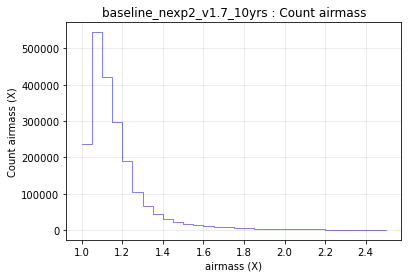

In [20]:
bundle_name = "baseline_nexp2_v1_7_10yrs_Count_airmass_ONED"
batches[run_name][bundle_name].plot()

Normally, you wouldn't do this in the same code that computed the metrics.

It created a set of files you can do further analysis on.
The `Comparing Runs` notebook shows how to use these files.
Here, we can just look at what the files were, and where it put them.

For each run, it created a `ResultsDb` database with summary data and metadata on the files it created:

In [21]:
!find $data_dir -name resultsDb_sqlite.db

/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_nexp2_v1.7_10yrs/bulk_example/resultsDb_sqlite.db
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_2snaps_v1.5_10yrs/bulk_example/resultsDb_sqlite.db
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_v2.0_10yrs/bulk_example/resultsDb_sqlite.db
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/long_gaps_nightsoff4_v2.0_10yrs/bulk_example/resultsDb_sqlite.db
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/footprint_4_v1.710yrs/bulk_example/resultsDb_sqlite.db
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/rolling_ns3_rw0.9_v2.0_10yrs/bulk_example/resultsDb_sqlite.db


It also created `numpy` save files with the metric values (and slicers):

In [22]:
!find $data_dir -name \*.npz

/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_nexp2_v1.7_10yrs/bulk_example/baseline_nexp2_v1_7_10yrs_OpenShutterFraction_UNIS.npz
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_nexp2_v1.7_10yrs/bulk_example/baseline_nexp2_v1_7_10yrs_Count_airmass_ONED.npz
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_nexp2_v1.7_10yrs/bulk_example/baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL.npz
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_nexp2_v1.7_10yrs/bulk_example/baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL.npz
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_2snaps_v1.5_10yrs/bulk_example/baseline_2snaps_v1_5_10yrs_OpenShutterFraction_UNIS.npz
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_2snaps_v1.5_10yrs

Finally, it created a set of plots, in both `pdf` and `png` formats:

In [23]:
!find $data_dir -name \*.pdf

/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_nexp2_v1.7_10yrs/bulk_example/baseline_nexp2_v1_7_10yrs_Count_airmass_ONED_BinnedData.pdf
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_nexp2_v1.7_10yrs/bulk_example/baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL_SkyMap.pdf
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_nexp2_v1.7_10yrs/bulk_example/baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL_Histogram.pdf
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_nexp2_v1.7_10yrs/bulk_example/baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL_SkyMap.pdf
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_nexp2_v1.7_10yrs/bulk_example/baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL_Histogram.pdf
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/bas

In [24]:
!find $data_dir -name \*.png

/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_nexp2_v1.7_10yrs/bulk_example/thumb.baseline_nexp2_v1_7_10yrs_Count_airmass_ONED_BinnedData.png
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_nexp2_v1.7_10yrs/bulk_example/thumb.baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL_SkyMap.png
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_nexp2_v1.7_10yrs/bulk_example/thumb.baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL_Histogram.png
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_nexp2_v1.7_10yrs/bulk_example/thumb.baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL_SkyMap.png
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf/tutorial/bulk_metric_data/baseline_nexp2_v1.7_10yrs/bulk_example/thumb.baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL_Histogram.png
/data/des91.b/data/neilsen/LSST/devel/rubin_sim_notebooks/maf

The results databases are `sqlite3` databases with metadata and summary information about the metrics run, including names of the files with the metrics and plots.
The `maf.ResultsDb` class provides access to this metadata; it's use is described in the `Comparing Runs` notebook.

It can also be used directly, for example by loading its contents into a `pandas.DataFrame`:

In [25]:
from os import path

resultsdb_fname = path.join(
    data_dir, "baseline_nexp2_v1.7_10yrs/bulk_example/resultsDb_sqlite.db"
)

In [26]:
import sqlite3
import pandas as pd

with sqlite3.connect(resultsdb_fname) as con:
    df = pd.read_sql("SELECT * FROM metrics", con, index_col="metricId")

df

,metricName,slicerName,simDataName,sqlConstraint,metricMetadata,metricDataFile
metricId,,,,,,
1,OpenShutterFraction,UniSlicer,baseline_nexp2_v1.7_10yrs,,,baseline_nexp2_v1_7_10yrs_OpenShutterFraction_...
2,Count airmass,OneDSlicer,baseline_nexp2_v1.7_10yrs,,,baseline_nexp2_v1_7_10yrs_Count_airmass_ONED.npz
3,CoaddM5,HealpixSlicer,baseline_nexp2_v1.7_10yrs,filter = 'g',g,baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL.npz
4,CoaddM5,HealpixSlicer,baseline_nexp2_v1.7_10yrs,filter = 'i',i,baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL.npz


In [27]:
with sqlite3.connect(resultsdb_fname) as con:
    df = pd.read_sql(
        "SELECT * FROM plots NATURAL JOIN metrics",
        con,
        index_col=["metricId", "plotId"],
    )

df

plotType  \
metricId plotId               
2        11      BinnedData   
4        12          SkyMap   
         13       Histogram   
3        14          SkyMap   
         15       Histogram   

                                                          plotFile  \
metricId plotId                                                      
2        11      baseline_nexp2_v1_7_10yrs_Count_airmass_ONED_B...   
4        12      baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL_SkyMa...   
         13      baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL_Histo...   
3        14      baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL_SkyMa...   
         15      baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL_Histo...   

                    metricName     slicerName                simDataName  \
metricId plotId                                                            
2        11      Count airmass     OneDSlicer  baseline_nexp2_v1.7_10yrs   
4        12            CoaddM5  HealpixSlicer  baseline_nexp2_v1.7_10yrs   
         13            CoaddM5  HealpixSlicer  baseline_nexp2_v1.7_10yrs   
3        14            CoaddM5  HealpixSlicer  baseline_nexp2_v1.7_10yrs   
         15            CoaddM5  HealpixSlicer  baseline_nexp2_v1.7_10yrs   

                sqlConstraint metricMetadata  \
metricId plotId                                
2        11                                    
4        12      filter = 'i'              i   
         13      filter = 'i'              i   
3        14      filter = 'g'              g   
         15      filter = 'g'              g   

                                                   metricDataFile  
metricId plotId                                                    
2        11      baseline_nexp2_v1_7_10yrs_Count_airmass_ONED.npz  
4        12          baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL.npz  
         13          baseline_nexp2_v1_7_10yrs_CoaddM5_i_HEAL.npz  
3        14          baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL.npz  
         15          baseline_nexp2_v1_7_10yrs_CoaddM5_g_HEAL.npz

In [28]:
with sqlite3.connect(resultsdb_fname) as con:
    df = pd.read_sql(
        "SELECT * FROM summarystats NATURAL JOIN metrics",
        con,
        index_col=["metricId", "statId"],
    )

df

summaryName   summaryValue           metricName  \
metricId statId                                                   
1        1         Identity       0.708027  OpenShutterFraction   
2        2             Mean   68183.100000        Count airmass   
         3              Rms  133240.794104        Count airmass   
         4           Median    6683.000000        Count airmass   
         5              Max  544349.000000        Count airmass   
         6              Min     258.000000        Count airmass   
         7       N(+3Sigma)       1.000000        Count airmass   
         8       N(-3Sigma)       0.000000        Count airmass   
         9            Count      30.000000        Count airmass   
         10        25th%ile    1782.750000        Count airmass   
         11        75th%ile   40629.250000        Count airmass   
3        12             Min      26.707464              CoaddM5   
         13          Median      26.902416              CoaddM5   
         14             Max      28.684006              CoaddM5   
4        15             Min      26.174608              CoaddM5   
         16          Median      26.357288              CoaddM5   
         17             Max      28.201292              CoaddM5   
1        18        Identity       0.708027  OpenShutterFraction   
2        19            Mean   68183.100000        Count airmass   
         20             Rms  133240.794104        Count airmass   
         21          Median    6683.000000        Count airmass   
         22             Max  544349.000000        Count airmass   
         23             Min     258.000000        Count airmass   
         24      N(+3Sigma)       1.000000        Count airmass   
         25      N(-3Sigma)       0.000000        Count airmass   
         26           Count      30.000000        Count airmass   
         27        25th%ile    1782.750000        Count airmass   
         28        75th%ile   40629.250000        Count airmass   
3        29             Min      26.707464              CoaddM5   
         30          Median      26.902416              CoaddM5   
         31             Max      28.684006              CoaddM5   
4        32             Min      26.174608              CoaddM5   
         33          Median      26.357288              CoaddM5   
         34             Max      28.201292              CoaddM5   
1        35        Identity       0.708027  OpenShutterFraction   
2        36            Mean   68183.100000        Count airmass   
         37             Rms  133240.794104        Count airmass   
         38          Median    6683.000000        Count airmass   
         39             Max  544349.000000        Count airmass   
         40             Min     258.000000        Count airmass   
         41      N(+3Sigma)       1.000000        Count airmass   
         42      N(-3Sigma)       0.000000        Count airmass   
         43           Count      30.000000        Count airmass   
         44        25th%ile    1782.750000        Count airmass   
         45        75th%ile   40629.250000        Count airmass   
4        46             Min      26.174608              CoaddM5   
         47          Median      26.357288              CoaddM5   
         48             Max      28.201292              CoaddM5   
3        49             Min      26.707464              CoaddM5   
         50          Median      26.902416              CoaddM5   
         51             Max      28.684006              CoaddM5   

                    slicerName                simDataName sqlConstraint  \
metricId statId                                                           
1        1           UniSlicer  baseline_nexp2_v1.7_10yrs                 
2        2          OneDSlicer  baseline_nexp2_v1.7_10yrs                 
         3          OneDSlicer  baseline_nexp2_v1.7_10yrs                 
         4          OneDSlicer  baseline_nexp2_v1.7_10yrs                 
         5    